# Abstract

We use two classic learning models from cognitive science to model learning in 19 participants who completed a two-alternative forced-choice task. The task consisted of two aliens (alternatives) and participants were instructed to select which option would win based on 2-4 features ($n$ of features condition). Additionally, the task was completed under a time pressure condition with a set time limit of 3 or 6s per trial. In our behavioral analyses we find indication of learning with improvement in performance across trials. We then continue to fit the parameters of our respective models including an $\epsilon$ value to capture noisiness in decision making. Here we find that Rescorla-Wagner fits the human data the best while Kalman filter provides a limited fit. After analyzing parameters we conclude that time pressure influences noisiness in decision making but does not influence learning rate. Similarly, we notice that the number of features influences decision noise but not learning rate.

# Introduction

Learning and decision making under uncertainty requires a good balance between exploration and explotation. Additionally, other factors like the complexity of the task, the degrees of freedom, and the time pressure can highly influence learning and decision making. Here, we investigate the effects of such complexities on the learning and decision making.

Existing literature suggests that with increased complexity the agent prefers exploitation over exploration. We expect to see this as lower decision noise and learning rate under the effects of time constraints, and the number of the features. So, we make the following hypotheses.

$H_1$ - Increasing number of features increases decision noise and decreases learning rate.  
$H_2$ - Time pressure decreases decision noise and learning rate.

Time pressure leads to faster vs. slower learning

Time pressure leads to noisier vs. less noisy decisions —> Time pressure leads to more random policy 

Time pressure leads to simpler vs. more complex learning strategies

Though classically Rescorla-Wagner has
RW vs. KF fits human data better

In [ ]:
# `Analysis`

In [120]:
## Imports
def load(arr, folder='/Users/joelvasama/Downloads/CCCP-Pulkit/pickles'):
    return np.load(f'{folder}/{arr}.npy')

In [26]:
import sys

In [27]:
from functools import lru_cache

In [28]:
import numpy as np

In [29]:
import pandas as pd

In [30]:
from scipy import optimize
import scipy.stats as st

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [32]:
import matplotlib.pyplot as plt

In [33]:
import seaborn as sns

In [34]:
from tqdm import tqdm

In [35]:
from IPython.display import display

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
## Data Reading and Pre-Processing

In [38]:
data = pd.read_csv('ccs2022.csv')
data.rename(columns={'Unnamed: 0':'semi_global_trial'}, inplace=True)

In [39]:
# Check for empty values
data.isna().any();

In [40]:
# Add column to mark when J is the correct response
data['J_correct'] = (data['yj'] > data['yf']).astype(int)

In [41]:
# Add column to mark when a correct choice was made
data['correct'] = (data['J_correct'] == data['J_pressed']).astype(int)

In [42]:
# Create unique task identifier for all participants
data['global_task'] = 100*data['slow'] + data['task']

In [43]:
data.head();

In [44]:
## Global Constants

In [45]:
NUM_TRIALS = data['trial'].nunique()

In [46]:
NUM_PARTICIPANTS = data['participant_id'].nunique()
PARTICIPANTS = data['participant_id'].unique().astype(int)

In [47]:
PRINT_ENABLE = False

In [48]:
## Global Functions

In [49]:
### Miscellaneous

In [50]:
def detect_outliers(x):
    q1 = np.quantile(x, 0.25) # Lower quartile
    q3 = np.quantile(x, 0.75) # Upper quartile
    
    iqr = q3-q1 # Interquartile range
    
    iqr_bounds = [q1 - (1.5 * iqr), q3 + (1.5 * iqr)] # Bounds
    
    outliers = x[(x <= iqr_bounds[0]) | (x >= iqr_bounds[1])] # Selecting data beyond bounds
    
    return outliers

In [51]:
def print_(*args, **kwargs):
    if PRINT_ENABLE:
        print(*args, **kwargs)

In [52]:
### Plotting

In [53]:
def boxplots(a, box_labels, ax, point_labels=PARTICIPANTS, title=None):
    df = pd.DataFrame(np.array([np.array(a_i).flatten() for a_i in a]).T, columns=box_labels)
    sns.boxplot(data=df, ax=ax, boxprops=dict(alpha=.3))
    sns.swarmplot(data=df, ax=ax)

    for i, k in enumerate(point_labels):
        for j, a_i in enumerate(a):
            ax.text(j, a_i[i], k, alpha=0.8)
    
    if title: ax.set_title(title)

In [54]:
### Decision Making

In [55]:
epsilon_greedy = lambda choice_function: lambda e: lambda *args, **kwargs: choice_function(*args, **kwargs) * (1 - e) + 0.5 * e

In [56]:
@epsilon_greedy
def softmax(s1, s2, *std): # Softmax Rule
    return 1/(1 + np.e**(s1 - s2))

In [57]:
@epsilon_greedy
def am(s1, s2, *std): # Accuracy Maximization
    return s1 < s2

In [58]:
@epsilon_greedy
def pm(s1, s2, std1, std2):
    return np.random.normal(s1, std1) < np.random.normal(s2, std2)

In [59]:
@epsilon_greedy
def sb(s1, s2, std1, std2, n_samples=10):
    return np.count_nonzero(np.random.normal(s1, std1, (1, n_samples)) > np.random.normal(s2, std2, (1, n_samples))) >= n_samples/2

In [60]:
### Scoring

In [61]:
# Bayesian Information Criterion
# > BIC = p.ln(t.k) - 2.LL
bic = lambda P, N, LL: P*np.log(N) - 2*LL

In [62]:
# Akaike Information Criterion
# > AIC = 2.p - 2.LL
aic = lambda P, N, LL: 2*P - 2*LL

In [63]:
### Model Fitting

In [64]:
# @lru_cache
def fit_model(participant_id,
              Model,
              model_params,
              choice_function=am(0),
              conditions={},
              feature_labels=[['xf0', 'xf1', 'xf2', 'xf3'], ['xj0', 'xj1', 'xj2', 'xj3']],
              target_labels=[['yf'], ['yj']],
              choice_label='J_pressed'):

    data_participant = data[data['participant_id'] == participant_id]
    if conditions:
        for condition in conditions:
            data_participant = data_participant[data_participant[condition] == conditions[condition]]

    ## num_tasks = data_participant['global_task'].nunique() # Find number of tasks
    tasks = data_participant['global_task'].unique() # Find the tasks that satisfy the conditions
    if not len(tasks):
        raise ValueError('No tasks with the given conditions.')

    log_likelihoods = {} # [num_tasks]
    for task in tasks: # For each task
        data_participant_task = data_participant[data_participant['global_task'] == task] # Focus on that task data

        num_features = int(data_participant_task['num_features'].unique()) # Find number of inputs for that task
        
        model = Model(num_features, *model_params) # Create Model instance with the number of inputs and passed model parameters

        log_likelihood = []
        for trial in data_participant_task['trial'].unique(): # For each trial
            data_participant_task_trial = data_participant_task[data_participant_task['trial'] == trial] # Focus on that trial data

            # Extract input and target arrays, and choice, using (default) labels passed in function call
            inputs = [data_participant_task_trial[feature_labels_i[:num_features]].to_numpy().reshape((-1, 1)) for feature_labels_i in feature_labels]
            targets = [data_participant_task_trial[target_labels_i].to_numpy().reshape((-1, 1)) for target_labels_i in target_labels]

            # Make predictions
            means, std = np.array([np.array(model.predict(inputs_i)).flatten() for inputs_i in inputs]).T

            # Learn model
            for inputs_i, target in zip(inputs, targets):
                model.learn(inputs_i, target)

            # Make decision
            p_choice = choice_function(*means, *std)

            likelihood = p_choice if int(data_participant_task_trial[choice_label]) == 1 else 1-p_choice
            
            # Calculate log-likelihood
            log_likelihood.append(np.log(likelihood if likelihood else sys.float_info.min)) # corresponding to the lowest log(float) possible

        log_likelihoods[task] = log_likelihood

    return log_likelihoods

In [65]:
def pick_tasks(participant_id, conditions={}): # {'num_features': 2}, {'num_features': 3}, {'num_features': 4}, {'slow': 1}, {'slow': 0}
    # def create_condition(key, param):
    #     if key == 'all':
    #         return []
    #     else:
    #         try:
    #             return {key: int(param)}
    #         except ValueError:
    #             raise ValueError('Invalid Condition!')

    data_participant = data[data['participant_id'] == participant_id]
    
    if conditions: # If there are conditions
        for condition in conditions: # Apply conditions iteratively
            data_participant = data_participant[data_participant[condition] == conditions[condition]]
    
    tasks = data_participant['global_task'].unique() # Find the tasks that satisfy the conditions
    
    if not len(tasks):
        raise ValueError('No tasks with the given conditions.')

    return tasks

In [66]:
### Optimizing

In [67]:
def no_search(func, rrange):
    return np.arange(*rrange[0])[0], func(np.arange(*rrange[0])[:1])

In [68]:
def optimise(Model,
             model_search_space=(),
             search_algorithm=lambda *args, **kwargs: optimize.brute(*args, **kwargs, full_output=True, finish=None),
             error_search_space=(0, 1, 0.1),
             choice_function=softmax,
             xic=bic,
             conditions={}):
    
    if len(model_search_space) != Model._num_params:
        raise ValueError(f'Not enough model search parameters specified. Required {Model._num_params} parameters.')
    
    xics = []
    optimal_model_params = []
    optimal_error = []
        
    for participant_id in tqdm(data['participant_id'].unique()):
        tasks = pick_tasks(participant_id, conditions)

        def llfunc(model_error_params):
            log_likelihoods = fit_model(participant_id, Model, tuple(model_error_params)[:-1], choice_function(model_error_params[-1]), conditions)
            return -sum([sum(log_likelihoods[task]) for task in tasks])
        
        optimal_model_error_params, fval, *_ = search_algorithm(llfunc, model_search_space + (error_search_space,))
        
        xics.append(xic(len(model_search_space)+1, len(tasks)*NUM_TRIALS, -fval))
        optimal_model_params.append(optimal_model_error_params[:-1])
        optimal_error.append(optimal_model_error_params[-1])
    
    return np.array(xics), np.array(optimal_model_params), np.array(optimal_error)

In [69]:
## Outlier Detection

In [70]:
#The most important columns for analysis are participant accuracy and reaction time as these reflect performance in the experiment.

In [71]:
#`Outlier Detection (Accuracy)`

In [72]:
# Average accuracy
avg_correct = data['correct'].mean()
print_(f'Average accuracy: {avg_correct:.3f}')

In [73]:
# Participant accuracy
par_correct = data.groupby('participant_id')['correct'].mean()
print_(par_correct.to_frame())

In [74]:
print_(detect_outliers(par_correct))

In [75]:
#`Outlier Detection (Reaction Time)`

In [76]:
par_RT = data.groupby('participant_id')['decision_time'].mean()
print_(par_RT.to_frame())

In [77]:
print_(detect_outliers(par_RT));

In [78]:
#`Outlier Detection | Summary`

In [82]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 4));
# boxplots([par_correct], ['Accuracy'], ax[0])
# boxplots([par_RT], ['Reaction Time'], ax[1])
# fig.suptitle('Outlier Detection');

In [ ]:
### Excluding Outliers

In [42]:
data_ = data[data['participant_id'] != 18] # Excluding participant 18

In [43]:
# Computing new means after exclusion
avg_correct = data_['correct'].mean()
par_correct = data_.groupby('participant_id').correct.mean()
par_RT = data_.groupby('participant_id').decision_time.mean()

In [ ]:
## Behavioral Analysis

In [ ]:
#### Do participants perform better than chance?

In [44]:
print_(f'Average accuracy: {avg_correct}')
t_par, p_par = st.ttest_1samp(par_correct, 0.5)
print_(f't = {t_par} ; p = {p_par}')

In [ ]:
#### Do they improve over trials within each round?

In [45]:
data_.groupby('trial').correct.mean();

In [46]:
smf.ols(formula='correct ~ trial', data=data_).fit().summary();

In [ ]:
#### Do they improve over rounds?

In [47]:
data_.groupby(['task', 'slow']).correct.mean();

In [48]:
smf.ols(formula='correct ~ task', data=data_).fit().summary();

In [ ]:
#### How does the number of observed features affect performance?

In [49]:
data_.groupby('num_features').correct.mean();

In [278]:
smf.ols(formula='correct ~ num_features', data=data_).fit().summary();

In [ ]:
#### How does time pressure affect performance?

In [51]:
data_.groupby('slow').correct.mean();

In [52]:
t_slow_fast, p_slow_fast = st.ttest_rel(data_[data_['slow'] == 0].correct, data_[data_['slow'] == 1].correct)
print_(f't = {t_slow_fast}, p = {p_slow_fast}')

In [ ]:
### Does RT affect performnce?

In [53]:
data_.groupby('participant_id')[['decision_time', 'correct']].mean();

In [54]:
st.pearsonr(par_correct, par_RT);

In [55]:
smf.ols(formula='correct ~ num_features * C(slow) * decision_time', data=data_).fit().summary();

In [ ]:
### Bigression

In [56]:
smf.ols(formula='correct ~ num_features * C(slow) * decision_time', data=data_).fit().summary();

In [ ]:
## Parameter Fitting

In [ ]:
### Rescorla-Wagner

In [57]:
class RescorlaWagner():
    _num_params = 1

    def __init__(self, num_features, learning_rate):
        self.num_features = num_features
        self.learning_rate = learning_rate
        
        self.weights = np.zeros((num_features, 1))
        
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        return mean, [[0]]
        
    def learn(self, inputs, targets):
        self.weights = self.weights + self.learning_rate * (targets - self.weights.T @ inputs) * inputs

In [58]:
# bics_rw, optimal_model_params_rw, optimal_error_rw = optimise(RescorlaWagner, ((0, 1, 0.1),))

In [94]:
#bics_rw_slow, optimal_model_params_rw_slow, optimal_error_rw_slow = optimise(RescorlaWagner, ((0, 1, 0.1),), conditions={'slow': 1})

In [95]:
#bics_rw_fast, optimal_model_params_rw_fast, optimal_error_rw_fast = optimise(RescorlaWagner, ((0, 1, 0.1),), conditions={'slow': 0})

In [93]:
#st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])

In [83]:
# fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants')
# ax[0].bar(PARTICIPANTS - 0.175, optimal_error_rw_slow, 0.35, label='Slow', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.175, optimal_error_rw_fast, 0.35, label='Fast', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots(optimal_error_rw_slow, optimal_error_rw_fast, ('Slow', 'Fast'), ax[1])

In [92]:
#st.ttest_rel(optimal_error_rw_slow[:18], optimal_error_rw_fast[:18])

In [ ]:
### Kalman Filter

In [65]:
class KalmanFilter():
    _num_params = 2 
    
    def __init__(self, num_features, sigma_y, sigma_w):
        self.num_features = num_features
        self.sigma_y = sigma_y
        self.sigma_w = sigma_w
        
        self.weights = np.zeros((num_features, 1))
        self.covariance = sigma_w * np.eye(num_features)
        
    def predict(self, inputs):
        mean = self.weights.T @ inputs
        std = np.sqrt(inputs.T @ self.covariance @ inputs + self.sigma_y ** 2)
        return mean, std

    def learn(self, inputs, targets):
        kalman_numerator = self.covariance @ inputs
        kalman_denominator = inputs.T @ self.covariance @ inputs + self.sigma_y ** 2
        kalman_gain = kalman_numerator / kalman_denominator
        
        self.weights = self.weights + kalman_gain * (targets - self.weights.T @ inputs)
        self.covariance = self.covariance - kalman_gain @ inputs.T @ self.covariance

In [66]:
# bics_kf, optimal_model_params_kf, optimal_error_kf = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)))

In [96]:
#bics_kf_slow, optimal_model_params_kf_slow, optimal_error_kf_slow = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)), conditions={'slow': 1})

In [97]:
#bics_kf_fast, optimal_model_params_kf_fast, optimal_error_kf_fast = optimise(KalmanFilter, ((0.1, 1, 0.1), (0.1, 1, 0.1)), conditions={'slow': 0})

In [84]:
# fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal $\sigma_y$ Across Participants')
# ax[0].bar(PARTICIPANTS - 0.175, optimal_model_params_kf_slow[:, 0], 0.35, label='Slow', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.175, optimal_model_params_kf_fast[:, 0], 0.35, label='Fast', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots(optimal_model_params_kf_slow[:, 0], optimal_model_params_kf_fast[:, 0], ('Slow', 'Fast'), ax[1])

In [91]:
#st.ttest_rel(optimal_model_params_kf_slow[:18, 0], optimal_model_params_kf_fast[:18, 0])

In [85]:
# fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants')
# ax[0].bar(PARTICIPANTS - 0.175, np.array(optimal_error_kf_slow).squeeze(), 0.35, label='Slow', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.175, np.array(optimal_error_kf_fast).squeeze(), 0.35, label='Fast', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots(optimal_error_kf_slow, optimal_error_kf_fast, ('Slow', 'Fast'), ax[1])

In [90]:
#st.ttest_rel(optimal_error_kf_slow[:18], optimal_error_kf_fast[:18])

In [ ]:
### Random Model

In [73]:
# bics_rm = np.array([bic(0, NUM_TRIALS*data['global_task'].nunique(), NUM_TRIALS*data['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

In [74]:
bics_rm_slow = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

In [75]:
bics_rm_fast = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

In [98]:
#bics_rw_slow_2, optimal_model_params_rw_slow_2, optimal_error_rw_slow_2 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 1, 'num_features': 2})

In [99]:
#bics_rw_slow_3, optimal_model_params_rw_slow_3, optimal_error_rw_slow_3 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 1, 'num_features': 3})

In [100]:
#bics_rw_slow_4, optimal_model_params_rw_slow_4, optimal_error_rw_slow_4 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 1, 'num_features': 4})

In [101]:
#bics_rw_fast_2, optimal_model_params_rw_fast_2, optimal_error_rw_fast_2 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 0, 'num_features': 2})

In [102]:
#bics_rw_fast_3, optimal_model_params_rw_fast_3, optimal_error_rw_fast_3 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 0, 'num_features': 3})

In [103]:
#bics_rw_fast_4, optimal_model_params_rw_fast_4, optimal_error_rw_fast_4 = optimise(RescorlaWagner, ((0, 1.1, 0.1),), conditions={'slow': 0, 'num_features': 4})

In [ ]:
#### Does increasing the number of features lead to slower learning?

In [86]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Learning Rate Across Participants (Slow Tasks)')
# ax[0].bar(PARTICIPANTS - 0.23, optimal_model_params_rw_slow_2[:, 0], 0.23, label='2', alpha=0.8)
# ax[0].bar(PARTICIPANTS, optimal_model_params_rw_slow_3[:, 0], 0.23, label='3', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.23, optimal_model_params_rw_slow_4[:, 0], 0.23, label='4', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots([optimal_model_params_rw_slow_2, optimal_model_params_rw_slow_3, optimal_model_params_rw_slow_4], ('2', '3', '4'), ax[1])

In [279]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='learning_rate ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_model_params_rw_slow_2), [3]*len(optimal_model_params_rw_slow_3), [4]*len(optimal_model_params_rw_slow_4)]),
            'learning_rate': np.concatenate([optimal_model_params_rw_slow_2[:, 0], optimal_model_params_rw_slow_3[:, 0], optimal_model_params_rw_slow_4[:, 0]])
        })).fit().summary();

In [87]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Learning Rate Across Participants (Fast Tasks)')
# ax[0].bar(PARTICIPANTS - 0.23, optimal_model_params_rw_fast_2[:, 0], 0.23, label='2', alpha=0.8)
# ax[0].bar(PARTICIPANTS, optimal_model_params_rw_fast_3[:, 0], 0.23, label='3', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.23, optimal_model_params_rw_fast_4[:, 0], 0.23, label='4', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots([optimal_model_params_rw_fast_2, optimal_model_params_rw_fast_3, optimal_model_params_rw_fast_4], ('2', '3', '4'), ax[1])

In [288]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='learning_rate ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_model_params_rw_fast_2), [3]*len(optimal_model_params_rw_fast_3), [4]*len(optimal_model_params_rw_fast_4)]),
            'learning_rate': np.concatenate([optimal_model_params_rw_fast_2[:, 0], optimal_model_params_rw_fast_3[:, 0], optimal_model_params_rw_fast_4[:, 0]])
        })).fit().summary();

In [ ]:
#### Does increasing the number of features lead to noisy decisions?

In [88]:
# fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants (Slow Tasks)')
# ax[0].bar(PARTICIPANTS - 0.23, optimal_error_rw_slow_2, 0.23, label='2', alpha=0.8)
# ax[0].bar(PARTICIPANTS, optimal_error_rw_slow_3, 0.23, label='3', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.23, optimal_error_rw_slow_4, 0.23, label='4', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots([optimal_error_rw_slow_2, optimal_error_rw_slow_3, optimal_error_rw_slow_4], ('2', '3', '4'), ax[1])

In [315]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='epsilon_error ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_error_rw_slow_2), [3]*len(optimal_error_rw_slow_3), [4]*len(optimal_error_rw_slow_4)]),
            'epsilon_error': np.concatenate([optimal_error_rw_slow_2, optimal_error_rw_slow_3, optimal_error_rw_slow_4])
        })).fit().summary();

In [89]:
# fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants (Fast Tasks)')
# ax[0].bar(PARTICIPANTS - 0.23, optimal_error_rw_fast_2, 0.23, label='2', alpha=0.8)
# ax[0].bar(PARTICIPANTS, optimal_error_rw_fast_3, 0.23, label='3', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.23, optimal_error_rw_fast_4, 0.23, label='4', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4], ('2', '3', '4'), ax[1])

In [316]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='epsilon_error ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_error_rw_fast_2), [3]*len(optimal_error_rw_fast_3), [4]*len(optimal_error_rw_fast_4)]),
            'epsilon_error': np.concatenate([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4])
        })).fit().summary();

In [318]:
pairwise_tukeyhsd(np.concatenate([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4]),
                  np.concatenate([[2]*len(optimal_error_rw_fast_2), [3]*len(optimal_error_rw_fast_3), [4]*len(optimal_error_rw_fast_4)])).summary();

# Methods

## Participant and Data

Anonymous data collected from 19 participants was provided without demographic variables other than source (Computational Cognitive Science class at University of Tübingen). Data from 1 of the 19 participants, participant number 18, was excluded from our analyses after being identified as an outlier, performing significantly better than the rest of the sample with both notably higher accuracy ($M$ = 89% vs. 63.3%) and faster reaction time ($M$ = 675.16 ms vs. 2131.19 ms). The reaction time of participant number 11 was also identified as an outlier ($M$ = 3072.21 ms vs. 2131.19 ms) but as their accuracy was normal we decided to keep this participant (see fig. 1).

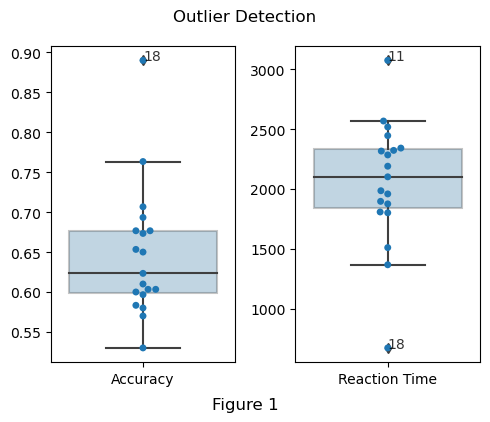

In [578]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4))
boxplots([par_correct], ['Accuracy'], ax[0], point_labels=['']*11 + [''] + ['']*6 + [18])
boxplots([par_RT], ['Reaction Time'], ax[1], point_labels=['']*11 + [11] + ['']*6 + [18])
fig.suptitle('Outlier Detection')
plt.figtext(0.5, -0.02, 'Figure 1', wrap=True, horizontalalignment='center', fontsize=12)
plt.tight_layout()

## Task

A two-alternative forced choice task was used to investigate learning in the participants. Participants went through 30 blocks of 10 trials. In each trial the goal was to determine which of two aliens win an abstract, non-visualized game based on 2, 3 or 4 features (number of features condition) provided to the participant under either a 3s (fast) or 6s (slow) time limit (time-pressure condition). The first 15 blocks were either in the slow or fast time pressure condition while the last 15 would be in the other, with this order of time-pressure conditions being counter-balanced between subjects. The number of features for each block were set constant but randomized within these 15 set blocks resulting in 5 sets of each 2, 3, or 4 features per time-pressure condition. Each of the features of each alien (2 to 4D vectors $x_{t,F}$ and $x_{t,J}$) were generated using a Gaussian distribution with a mean ($M$) of 0 and a standard deviation ($sd$) of 1. These were further weighted $w$ using a Gaussian distribution of $M$ = 0 and $sd$ = 1, defining which of the aliens won based on $y_{t,F}$ = $w^\top x_{t,F}$ and $y_{t,J}$ = $w^\top x_{t,J}$.

## Modeling

### Learning Models

We compared two classic learning models of cognition against a random policy to model learning in participants.  
1. Rescorla-Wagner  
2. Kalman Filter

### Decision-Making

For more accurate likelihood calculations, we wanted a decision algorithm that outputs a non-binary choice probability and wanted to be learning model agnostic, so we chose Softmax. Additionally, to model errors, we added an $\epsilon$-greedy error rule on top of the decision making process. The epsilon value was added as a search parameter during parameter fitting/optimisation. 

### Scoring Criterion

We choose to use the Bayesian Information Criterion (BIC) as our performance measure as our goal is to find the best fitting model or maximise the posterior probability.

### Model Fitting

We used grid search with sufficient precision for optimisatioe because of its ease of implementation, availability in standard Python libraries, and potential for caching (leading to faster computations when re-running analysis on different subsets of tasks).  

For accuracy validation, we compared it with other more accurate optimization techniques. The comparisons resulted in minimal differences in BIC scores to the Grid Search optimization. Moreover, the run-times were comparable.

# Results

## Behavioral

A one-sample t-test against a 50% chance level (participants had two alternatives) confirmed that participants performed on average above chance level ($t$(17) = 9.75, $p$ < 0.05) with an total average accuracy of 63.3% across all participants. 

&emsp; We then proceeded to complete five linear regression analyses to examine performance in trials and tasks, the influence of the number of features on performance, and the relationship between reaction time and performance. Regressing performance on trial within block, the first analysis indicated that participants perform better with each trial within blocks ($\beta$ = 0.014, $R^2$ = 0.007, $p$ < 0.001). On average, participants perform 1.4% better each trial after the first, suggesting participants indeed learn the task. In our second analysis we regressed performance on block, finding statistically significant relationship ($p$ = 0.329) suggesting participant performance did not vary within blocks. However, including the starting condition as a covariate resulted in a significant relationship ($\beta_{block}$ = 0.0007, $\beta_{start}$ = 0.0475, $R^2$ = 0.002, $p$ = 0.003), though only finding the starting condition as a significant regressand ($p_{block}$ = 0.329, $p_{start}$ = 0.001). Our third analysis regressing performance on number of features found a statistically significant relationship ($\beta$ = -0.043, $R^2$ = 0.005, $p$ < 0.001), indicating that the addition of each feature decreases accuracy on average by 4.3%. In other words, this suggests learning became more difficult with the addition of each feature. Finally, in the fourth analysis regressing performance on reaction time we found a that higher reaction time generally resulted in better accuracy ($\beta$ = 0.00005, $R$ = 0.011, $p$ < 0.001) with a 0.5% increase in accuracy for every 100ms. However, an additional Pearson's correlation test suggested no statistically significant relationship ($r$ = -0.43, $p$ = 0.07).

&emsp; We also performed two additional t-tests to examine the differences in performance due to time-pressure condition and starting time-pressure condition. Using a related samples t-test we found that participant perform of average 4.5% better ($M_{fast}$ = 61% vs. $M_{slow}$ = 65.5%) in slow trials ($t$(17) = -3.5, $p$ < 0.001), possibly due to having the ability to better consider the features. In contrast, an independent samples t-test showed no differences in participant performance resulting from  first encountered the slow condition instead of the fast condition ($t$(17) = -1.69, $p$ = 0.121). We also tested for a difference in reaction time between time-pressure conditions, and found that participants took almost 1s less to respond in the fast vs. slow condition ($t$(17) = -37.087, $p$ < 0.001, $M_{fast}$ = 1630.56 ms vs. $M_{slow}$ = 2631.83 ms).

## Model Comparison

In the heatmaps below (fig. 2 and 3), we include participant 18 due to the interesting performance they exhibited.

In [149]:
bics_rw_slow = load('bics_rw_slow')
optimal_model_params_rw_slow = load('optimal_model_params_rw_slow')
optimal_error_rw_slow = load('optimal_error_rw_slow')

bics_rw_fast = load('bics_rw_fast')
optimal_model_params_rw_fast = load('optimal_model_params_rw_fast')
optimal_error_rw_fast = load('optimal_error_rw_fast')

bics_kf_slow = load('bics_kf_slow')
optimal_model_params_kf_slow = load('optimal_model_params_kf_slow')
optimal_error_kf_slow = load('optimal_error_kf_slow')

bics_kf_fast = load('bics_kf_fast')
optimal_model_params_kf_fast = load('optimal_model_params_kf_fast')
optimal_error_kf_fast = load('optimal_error_kf_fast')

bics_rm_slow = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 1]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)
bics_rm_fast = np.array([bic(0, NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique(), NUM_TRIALS*data[data['slow'] == 0]['global_task'].nunique()*np.log(0.5))] * NUM_PARTICIPANTS)

bics_slow = pd.DataFrame({'RW_SLOW': bics_rw_slow, 'KF_SLOW': bics_kf_slow, 'RM_SLOW': bics_rm_slow})
bics_fast = pd.DataFrame({'RW_FAST': bics_rw_fast, 'KF_FAST': bics_kf_fast, 'RM_FAST': bics_rm_fast})
bics_net = pd.DataFrame({m: bics_slow[f'{m}_SLOW'] + bics_fast[f'{m}_FAST'] - p*np.log(300) for m, p in zip(['RW', 'KF', 'RM'], [2, 3, 0])})

counts_slow = {'RW_SLOW': 0, 'KF_SLOW': 0, 'RM_SLOW': 0}
for key, val in zip(*np.unique(bics_slow.columns[np.argmin(np.array(bics_slow[:18]), axis=1)], return_counts=True)):
    counts_slow[key] = val

counts_fast = {'RW_FAST': 0, 'KF_FAST': 0, 'RM_FAST': 0}
for key, val in zip(*np.unique(bics_fast.columns[np.argmin(np.array(bics_fast[:18]), axis=1)], return_counts=True)):
    counts_fast[key] = val

In [163]:
bics_slow = pd.DataFrame({'RW_SLOW': bics_rw_slow, 'KF_SLOW': bics_kf_slow, 'RM_SLOW': bics_rm_slow})
bics_fast = pd.DataFrame({'RW_FAST': bics_rw_fast, 'KF_FAST': bics_kf_fast, 'RM_FAST': bics_rm_fast})

In [164]:
bics_net = pd.DataFrame({m: bics_slow[f'{m}_SLOW'] + bics_fast[f'{m}_FAST'] - p*np.log(300) for m, p in zip(['RW', 'KF', 'RM'], [2, 3, 0])})

In [190]:
counts_slow = {'RW_SLOW': 0, 'KF_SLOW': 0, 'RM_SLOW': 0}
for key, val in zip(*np.unique(bics_slow.columns[np.argmin(np.array(bics_slow[:18]), axis=1)], return_counts=True)):
    counts_slow[key] = val

counts_fast = {'RW_FAST': 0, 'KF_FAST': 0, 'RM_FAST': 0}
for key, val in zip(*np.unique(bics_fast.columns[np.argmin(np.array(bics_fast[:18]), axis=1)], return_counts=True)):
    counts_fast[key] = val

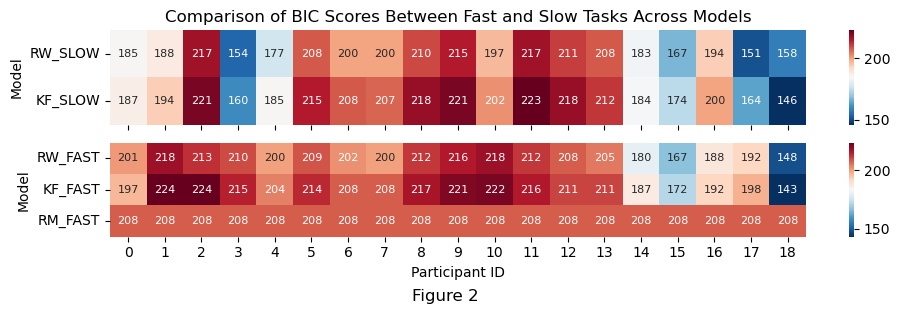

In [559]:
fig, axs = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

sns.heatmap(bics_slow.applymap(round)[['RW_SLOW', 'KF_SLOW']].T, cmap='RdBu_r', annot=True, fmt='g', ax=axs[0], annot_kws={'fontsize': 8})
# axs[0].set_title('BIC (Slow Tasks)')
# axs[0].set_xlabel('Participant ID')
axs[0].set_ylabel('Model')

sns.heatmap(bics_fast.applymap(round)[['RW_FAST', 'KF_FAST', 'RM_FAST']].T, cmap='RdBu_r', annot=True, fmt='g', ax=axs[1], annot_kws={'fontsize': 8})
# axs[1].set_title('BIC (Fast Tasks)')
axs[1].set_xlabel('Participant ID')
axs[1].set_ylabel('Model')

axs[0].set_title('Comparison of BIC Scores Between Fast and Slow Tasks Across Models')

plt.figtext(0.45, -0.02, 'Figure 2', wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()

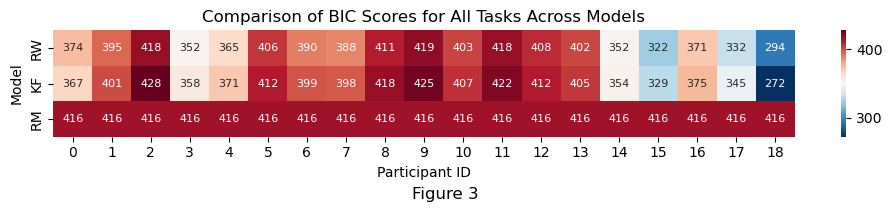

In [560]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), sharex=True)

sns.heatmap(bics_net.applymap(round)[['RW', 'KF', 'RM']].T, cmap='RdBu_r', annot=True, fmt='g', ax=ax, annot_kws={'fontsize': 8})
ax.set_xlabel('Participant ID')
ax.set_ylabel('Model')

ax.set_title('Comparison of BIC Scores for All Tasks Across Models')

plt.figtext(0.45, -0.02, 'Figure 3', wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()

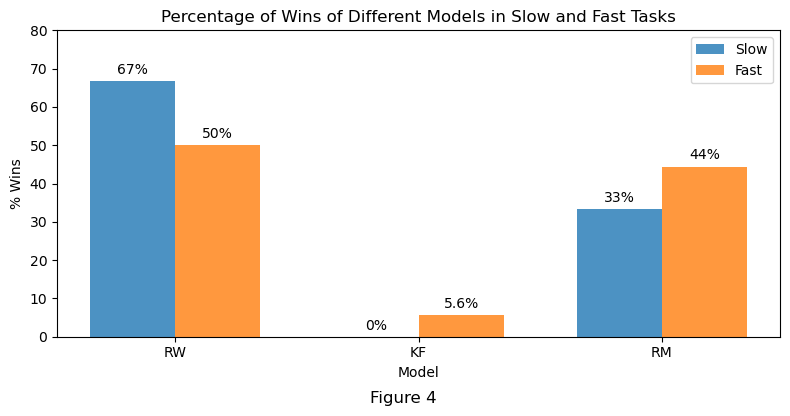

In [564]:
plt.figure(figsize=(8, 4))

plt.bar_label(plt.bar(np.arange(len(counts_slow)) - 0.175, list(counts_slow.values())/sum(list(counts_slow.values()))*np.float64(100), 0.35, label='Slow', alpha=0.8), fmt='%0.2g%%', padding=3)
plt.bar_label(plt.bar(np.arange(len(counts_fast)) + 0.175, list(counts_fast.values())/sum(list(counts_fast.values()))*np.float64(100), 0.35, label='Fast', alpha=0.8), fmt='%0.2g%%', padding=3)

plt.xticks(range(len(counts_slow)), ['RW', 'KF', 'RM'])

plt.ylim((0, 80))

plt.xlabel('Model')
plt.ylabel('% Wins')

plt.legend()

plt.title('Percentage of Wins of Different Models in Slow and Fast Tasks')

plt.figtext(0.51, -0.02, 'Figure 4', wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()

Comparison of the BIC scores of the best performing models (fig. 4) reveal that Rescorla Wagner model explains the human data best, with and without time pressure (\~67% without time pressure and \~50% with time pressure), followed by the random model (\~33% without time pressure and \~44% with time pressure), and finally by the Kalman Filter (\~0% without time pressure and \~6% with time pressure).  

However, for participant 18 in particular, the Kalman Filter model atypically performs best. This is expected because this participant was an ideal particiant (a bot) that indeed employed Kalman Filter to learn, but the BIC score is not low enough (for an ideal learner) because there was some artificial randomness added for realism, and thus the $\epsilon$ error value for the best fitting Kalman Filter model for participant 18 is also not zero.  

The parameter recovery resulted in almost the same parameters ($\sigma_y$ = 0.1, $\sigma_w$ = 0.9) of the Kalman Filter model that the bot employed ($\sigma_y$ = 0.1, $\sigma_w$ = 1). ($\sigma_w$ is not the same because $\sigma_w$ > 0.9 was not included in the search space [0, 0.9]).  

Based on these results we conclude that participants tend use a simpler learning strategy, such as those formulated in the Rescorla-Wagner and Random Policy models, in general and especially under time-pressure. 

## Parameter Analysis

In [190]:
bics_rw_slow_2 = load('bics_rw_slow_2')
optimal_model_params_rw_slow_2 = load('optimal_model_params_rw_slow_2')
optimal_error_rw_slow_2 = load('optimal_error_rw_slow_2')

bics_rw_slow_3 = load('bics_rw_slow_3')
optimal_model_params_rw_slow_3 = load('optimal_model_params_rw_slow_3')
optimal_error_rw_slow_3 = load('optimal_error_rw_slow_3')

bics_rw_slow_4 = load('bics_rw_slow_4')
optimal_model_params_rw_slow_4 = load('optimal_model_params_rw_slow_4')
optimal_error_rw_slow_4 = load('optimal_error_rw_slow_4')

bics_rw_fast_2 = load('bics_rw_fast_2')
optimal_model_params_rw_fast_2 = load('optimal_model_params_rw_fast_2')
optimal_error_rw_fast_2 = load('optimal_error_rw_fast_2')

bics_rw_fast_3 = load('bics_rw_fast_3')
optimal_model_params_rw_fast_3 = load('optimal_model_params_rw_fast_3')
optimal_error_rw_fast_3 = load('optimal_error_rw_fast_3')

bics_rw_fast_4 = load('bics_rw_fast_4')
optimal_model_params_rw_fast_4 = load('optimal_model_params_rw_fast_4')
optimal_error_rw_fast_4 = load('optimal_error_rw_fast_4')

### Rescorla-Wagner

We continue to analyze the fitted parameters of our models to gain further insight into the behaviour of the models. 

We first explored the influence of the time pressure condition on the learning rates of the Rescorla-Wagner model, finding no statistically significant difference between the slow or fast conditions (paired-samples, $t$(17) = -0.176, $p$ = 0.862). Considering the learning rate of Rescorla-Wagner to represent participant learning, this suggests that participants did not learn slower (or faster) under or without time pressure.  

Similarly, we note no difference in the fitted epsilon values between the time pressure conditions (paired-samples, $t$(17) = -1.350, $p$ = 0.195), suggesting that time pressure does not lead to noisier decisions. But if the number of features are two, we found that time pressure significantly affects the noisiness of decisions (paired-samples, $t$(17) = -2.667, $p$ = 0.016).  

We also tested whether the number of features lead to differences in learning or noisiness of decisions. Using linear mixed effects models, regressing learning rate on number of features we find no statistically significant relationship for slow ($p$ = 0.073) or fast ($p$ = 0.632) tasks, suggesting that the number of features, like time pressure, does not influence the rate of (especially fast) learning.  

However, we did find a positive relationship between number of features and epsilon ($\beta$ = 0.119, Marginal $R^2$ = 0.146, $p$ = 0.005), suggesting that increasing the number of features led to noisier decisions, possibly indicating more exploration. After performing a further Tukey's HSD test, we note that there are no differences in epsilon values between three and four features ($M_{diff}$ = -0.0184, $p$ = 0.9555), indicating that any features beyond two may not influence decision errors (see fig. 5).  

Also, although not statistically significant, increasing features might also lead to noisier decisions in fast tasks ($\beta$ = 0.086, Marginal $R^2$ = 0.075, $p$ = 0.057) (see fig. 6).

In [ ]:
#### Does increasing the number of features lead to slower learning?

In [186]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Learning Rate Across Participants (Slow Tasks)')
# ax[0].bar(PARTICIPANTS - 0.23, optimal_model_params_rw_slow_2[:, 0], 0.23, label='2', alpha=0.8)
# ax[0].bar(PARTICIPANTS, optimal_model_params_rw_slow_3[:, 0], 0.23, label='3', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.23, optimal_model_params_rw_slow_4[:, 0], 0.23, label='4', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots([optimal_model_params_rw_slow_2, optimal_model_params_rw_slow_3, optimal_model_params_rw_slow_4], ('2', '3', '4'), ax[1])

In [220]:
n_pam = len(optimal_model_params_rw_slow_2)
alphaFeat = pd.DataFrame({
            'num_features': np.concatenate([[2]*n_pam, [3]*n_pam, [4]*n_pam] * 2),
            'learning_rate': np.concatenate([optimal_model_params_rw_slow_2[:, 0], optimal_model_params_rw_slow_3[:, 0], optimal_model_params_rw_slow_4[:, 0],
                                             optimal_model_params_rw_fast_2[:, 0], optimal_model_params_rw_fast_3[:, 0], optimal_model_params_rw_fast_4[:, 0]]),
            'slow': np.repeat([1,0],57),
            'PID': np.repeat(range(0,19), 6)
            })

In [187]:
smf.ols(formula='learning_rate ~ num_features', 
        data=alphaFeat).fit().summary();

In [188]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Learning Rate Across Participants (Fast Tasks)')
# ax[0].bar(PARTICIPANTS - 0.23, optimal_model_params_rw_fast_2[:, 0], 0.23, label='2', alpha=0.8)
# ax[0].bar(PARTICIPANTS, optimal_model_params_rw_fast_3[:, 0], 0.23, label='3', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.23, optimal_model_params_rw_fast_4[:, 0], 0.23, label='4', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots([optimal_model_params_rw_fast_2, optimal_model_params_rw_fast_3, optimal_model_params_rw_fast_4], ('2', '3', '4'), ax[1])

In [189]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='learning_rate ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_model_params_rw_fast_2), [3]*len(optimal_model_params_rw_fast_3), [4]*len(optimal_model_params_rw_fast_4)]),
            'learning_rate': np.concatenate([optimal_model_params_rw_fast_2[:, 0], optimal_model_params_rw_fast_3[:, 0], optimal_model_params_rw_fast_4[:, 0]])
        })).fit().summary();

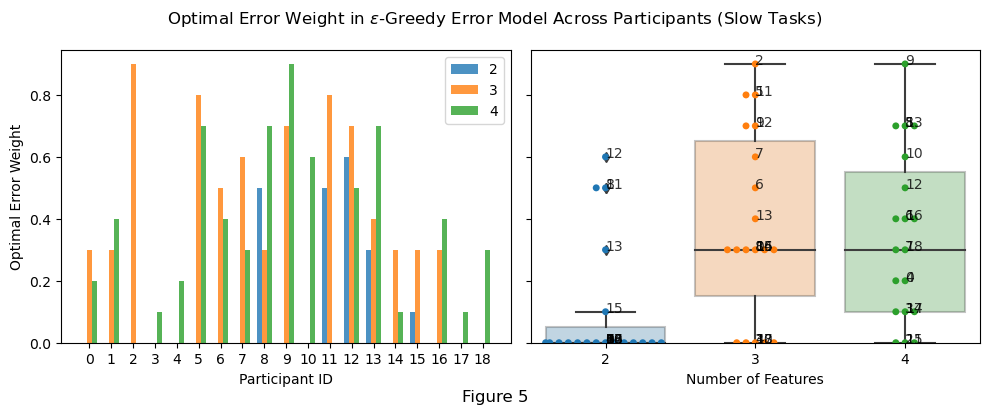

In [568]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants (Slow Tasks)')
ax[0].bar(PARTICIPANTS - 0.23, optimal_error_rw_slow_2, 0.23, label='2', alpha=0.8)
ax[0].bar(PARTICIPANTS, optimal_error_rw_slow_3, 0.23, label='3', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.23, optimal_error_rw_slow_4, 0.23, label='4', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Error Weight')

boxplots([optimal_error_rw_slow_2, optimal_error_rw_slow_3, optimal_error_rw_slow_4], ('2', '3', '4'), ax[1])
ax[1].set_xlabel('Number of Features')

plt.figtext(0.5, 0, 'Figure 5', wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()

In [197]:
n_pam = len(optimal_error_rw_slow_2)
epsiFeat = data=pd.DataFrame({
                'num_features': np.concatenate([[2]*n_pam, [3]*n_pam, [4]*n_pam] *2),
                'epsilon_error': np.concatenate([optimal_error_rw_slow_2, optimal_error_rw_slow_3, optimal_error_rw_slow_4,
                                                 optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4]),
                'slow': np.repeat([1,0],57)
                })

In [233]:
smf.mixedlm(formula='learning_rate ~ num_features', groups = alphaFeat['slow'],
        data=alphaFeat).fit().summary();

In [232]:
smf.ols(formula='learning_rate ~ num_features', 
        data=alphaFeat).fit().summary();

In [234]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='epsilon_error ~ num_features', 
        data=epsiFeat).fit().summary();

In [235]:
pairwise_tukeyhsd(epsiFeat['epsilon_error'], groups = epsiFeat['num_features']).summary();

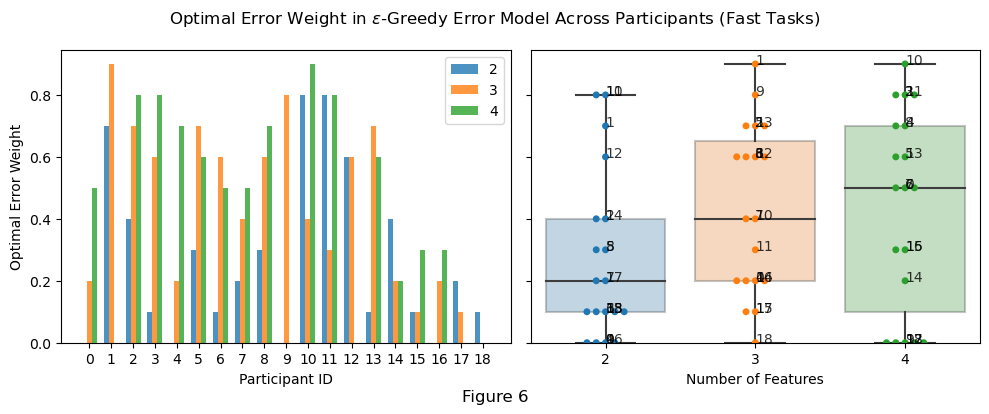

In [569]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), sharey=True)

fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants (Fast Tasks)')
ax[0].bar(PARTICIPANTS - 0.23, optimal_error_rw_fast_2, 0.23, label='2', alpha=0.8)
ax[0].bar(PARTICIPANTS, optimal_error_rw_fast_3, 0.23, label='3', alpha=0.8)
ax[0].bar(PARTICIPANTS + 0.23, optimal_error_rw_fast_4, 0.23, label='4', alpha=0.8)
ax[0].set_xticks(PARTICIPANTS)
ax[0].legend()
ax[0].set_xlabel('Participant ID')
ax[0].set_ylabel('Optimal Error Weight')

boxplots([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4], ('2', '3', '4'), ax[1])
ax[1].set_xlabel('Number of Features')

plt.figtext(0.5, 0, 'Figure 6', wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()

In [316]:
# st.ttest_rel(optimal_model_params_rw_slow[:18, 0], optimal_model_params_rw_fast[:18, 0])
smf.ols(formula='epsilon_error ~ num_features', 
        data=pd.DataFrame({
            'num_features': np.concatenate([[2]*len(optimal_error_rw_fast_2), [3]*len(optimal_error_rw_fast_3), [4]*len(optimal_error_rw_fast_4)]),
            'epsilon_error': np.concatenate([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4])
        })).fit().summary();

In [318]:
pairwise_tukeyhsd(np.concatenate([optimal_error_rw_fast_2, optimal_error_rw_fast_3, optimal_error_rw_fast_4]),
                  np.concatenate([[2]*len(optimal_error_rw_fast_2), [3]*len(optimal_error_rw_fast_3), [4]*len(optimal_error_rw_fast_4)])).summary();

### Kalman Filter

We completed similar analyses for the parameters obtained from the Kalman filter as we did for the Rescorla-Wagner model. 
<!-- However, these should be interpreted with caution considering the limitations in the fit the Kalman filter was able to obtain in comparison to the two other models.   -->

We used $\sigma_y$ (score confidence) to represent learning and tested whether it would be influenced by the time pressure conditions. Similar to the Rescorla-Wagner model analysis, a paired-samples t-test revealed no statistically significant differences in the mean value of $\sigma_y$ between normal and slow conditions ($t$(17) = -0.244, $p$ = 0.810).  

Furthermore, we explored noisiness in decision making using $\epsilon$ (error) to represent the stability, as before. No significant differences in time pressure conditions here we found here either (paired-samples, $t$(17) = -1.160, $p$ = 0.129).

In [236]:
# fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal $\sigma_y$ Across Participants')
# ax[0].bar(PARTICIPANTS - 0.175, optimal_model_params_kf_slow[:, 0], 0.35, label='Slow', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.175, optimal_model_params_kf_fast[:, 0], 0.35, label='Fast', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots(optimal_model_params_kf_slow[:, 0], optimal_model_params_kf_fast[:, 0], ('Slow', 'Fast'), ax[1])

In [237]:
# fig, ax = plt.subplots(1,2, figsize=(16, 4), sharey=True)

# fig.suptitle(r'Optimal Error Weight in $\epsilon$-Greedy Error Model Across Participants')
# ax[0].bar(PARTICIPANTS - 0.175, np.array(optimal_error_kf_slow).squeeze(), 0.35, label='Slow', alpha=0.8)
# ax[0].bar(PARTICIPANTS + 0.175, np.array(optimal_error_kf_fast).squeeze(), 0.35, label='Fast', alpha=0.8)
# ax[0].set_xticks(PARTICIPANTS)
# ax[0].legend();

# boxplots(optimal_error_kf_slow, optimal_error_kf_fast, ('Slow', 'Fast'), ax[1])

In [ ]:
## Miscellaneous

In [ ]:
### Comparison of Speed/Accuray of Optimisation Techniques

In [238]:
# bics_rw_slow_2_nm, optimal_model_params_rw_slow_2_nm, optimal_error_rw_slow_2_nm = optimise(RescorlaWagner,
#                             model_search_space=(0.5,),
#                             error_search_space=0.1,
#                             conditions={'slow': 1, 'num_features': 2},
#                             search_algorithm=lambda *args, **kwargs: [optimize.minimize(*args, **kwargs, bounds=((0, 1), (0, 1)), method='Nelder-Mead')[key] for key in ['x', 'fun']])

In [240]:
#np.mean(abs(bics_rw_slow_2_nm - bics_rw_slow_2));

# Discussion

We found that participants seem to learn the weights as they perform above chance level. <!-- ($t$ = 9.75, $p$ < 0.05), with an average accuracy of 63.3%. -->
Supporting this notion is the observed gradual improvement during blocks.
Additionally we observer an effect of time-pressure condition with participants performing better in slow tasks over fast tasks. This suggests that time indeed makes learning harder. 
<!-- (paired-samples, $t(17)$ = -3.5, $p$ < 0.001), performing on average 4.5% better in slow trials. -->
<!-- Performance improves over trials within task ($\beta$ = 0.014, $R^2$ = 0.007, $p$ < 0.001), on average 1.4% better each trial after the first. -->
<!-- 3. Performance doesn't really improve over rounds  ($p$ = 0.242). -->
<!-- 4. Higher reaction time generally resulted in better accuracy ($\beta$ = 0.00005, $R$ = 0.011, $p$ < 0.001), with a 0.5% increase in accuracy for every 100ms. However, an additional Pearson's correlation test suggested no statistically significant relationship ($r$ = -0.43, $p$ = 0.07) -->
From modelling, we see that the Rescorla Wagner model approximated human behaviour best in both slow and fast tasks.
Also, from insights gained from modeling we infer that participants prefer simpler learning strategies under time pressure making more random decisions.
Particularly, for two features, time pressure significantly increases noisiness of decisions.
<!-- (paired-samples, $t(17)$ = -2.667, $p$ = 0.016). -->
Finally, we note that addition of features decreases performance possibly due to increased difficulty, since participants need to take more information into account in their learning.
<!-- ($\beta$ = -0.043, $R^2$ = 0.005, $p$ < 0.001), with the addition of each feature decreasing accuracy on average by 4.3%. -->
This can also be seen by the increased noisiness in decisions with addition of features in regular (slow) tasks.
<!-- ($\beta$ = 0.119, Marginal $R^2$ = 0.146, $p$ = 0.005), with the addition of each feature increasing noisiness on average by 0.119. -->

Also, we found indication but could not statistically confirm that increasing features might lead to slower learning in regular (slow) tasks <!-- ($\beta$ = -0.072, Marginal $R^2$ = 0.057, $p$ = 0.073)  -->
and noisier decisions under time pressure (in fast tasks) <!-- ($\beta$ = 0.086, Marginal $R^2$ = 0.075, $p$ = 0.057) -->
.

Wu et al. (2019) found that participants seek out uncertain options when time is unlimited, but avoid uncertainty under time pressure (for a four-arm bandit task), but in our case, given two features, we infer that under time pressure the uncertainty increased. While the task paradigms are different because of the different number of choices (4 vs 2), we think that the contradiction might be because the participants weren't able to learn the association under time pressure (because there just wasn't enough time) and had to resort to random decisions (Fig. 6).

Further analysis can answer questions such as; does doing slow tasks first lead to better performance in subsequent fast tasks? Or, whether there's a significant correlation between reaction time and decision noisiness.

Building upon the work presented in this paper, potential improvements could be, comparison of more advanced learning models, like Heuristics, Neural Networks, Exemplar-Based Models, Gaussin Process etc.. Other decision making rules like Accuracy Maximisation, Probability Matching, Sample Based Rules, Drift Diffusion Models, Resource-rational Models can also be compared.

# References

Binz, M., Gershman, S.J., Schulz, E. and Endres, D., 2022. Heuristics from bounded meta-learned inference. *Psychological review.*

Schulz, E., Speekenbrink, M. and Krause, A., 2018. A tutorial on Gaussian process regression: Modelling, exploring, and exploiting functions. *Journal of Mathematical Psychology, 85, pp.1-16.*

Wu, C.M., Schulz, E., Gerbaulet, K., Pleskac, T.J. & Speekenbrink, M. (2019). Under pressure: The influence of time limits on human exploration. *Proceedings of the 41st Annual Conference of the Cognitive Science Society.*

---

[GitHub](https://github.com/pulkitgoyal56/CCCP) | [Website](https://pulkitgoyal56.github.io/CCCP/#/)